# Data Preprocessing-Imbalance
## Load Data And Dependencies

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [35]:
os.makedirs("data", mode=0o777, exist_ok=True)
X_train=pd.read_csv('data/X_train.csv')
y_train=pd.read_csv('data/y_train.csv')
X_test=pd.read_csv('data/X_test.csv')
y_test=pd.read_csv('data/y_test.csv')

df = pd.read_csv('data/ai4i2020_cleaned.csv')
labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
X = df.drop(columns=labels)
y = df[labels]

## Check For Imbalance Data

Percentages of each label in training data:
Machine failure: 2.57%
TWF: 0.39%
HDF: 1.18%
PWF: 0.05%
OSF: 0.84%
RNF: 0.17%


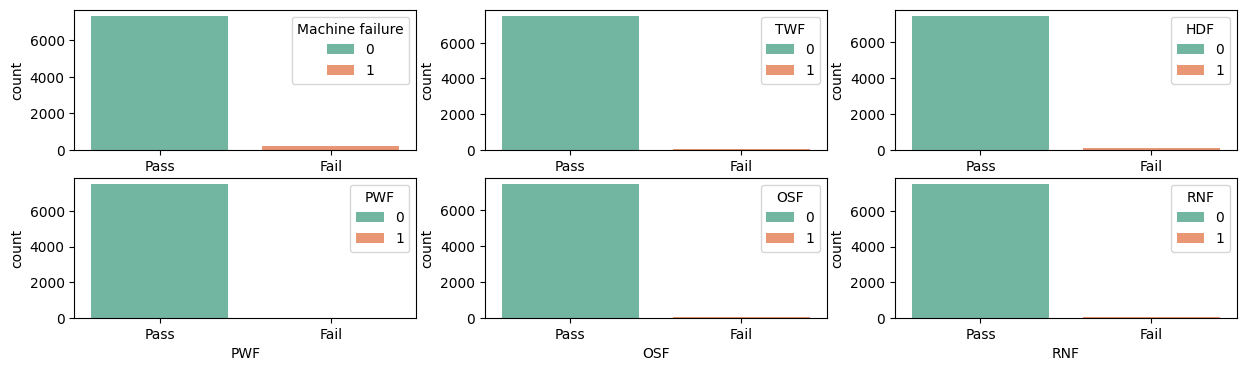

In [36]:
plt.figure(figsize=(15, 4))
percentages = y_train.mean() * 100
print("Percentages of each label in training data:")
for label, percentage in zip(labels, percentages):
    print(f"{label}: {percentage:.2f}%")
for index, label in enumerate(labels):
    plt.subplot(2, 3, index + 1) 
    sns.countplot(x=label, data=y_train, palette='Set2', hue=label, legend='full')
    plt.xticks([0, 1], ['Pass', 'Fail'])
plt.show()


We can observe that our data is highly imbalanced for all of our labels.

Machine Failure is only 3.48% and majority data is passing or not failed.

We should create a balanced dataset for our training to avoid majority bias

## Balancing Dataset

### Balancing using SMOTE for Machine Failure

In [37]:
%pip install imblearn
# Check if the imbalanced-learn package is installed
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
y_omf = y_train["Machine failure"]
X_resampled_train, y_resample_train = smote.fit_resample(X_train, y_omf)
print(f"Oversampling completed with {len(y_resample_train)} samples.")



Note: you may need to restart the kernel to use updated packages.
Oversampling completed with 14644 samples.


#### Saving SMOTE Balanced DataSet

In [38]:
X_resampled_train.to_csv('data/X_smote_train.csv', index=False)
y_resample_train.to_csv('data/y_smote_train.csv', index=False)

#### Visualize effect of balancing using SMOTE

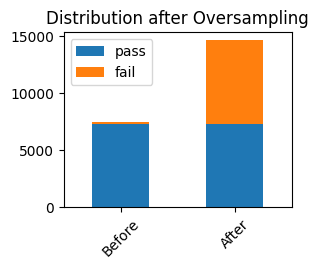

In [39]:

plt.figure(figsize=(10, 5))
before_count = y_omf.value_counts()
after_count = y_resample_train.value_counts()
temp = pd.DataFrame({'pass': [before_count[0], after_count[0]],
                        'fail': [before_count[1], after_count[1]], },
                    index=['Before', 'After'])
temp.plot(kind='bar', stacked=True, ax=plt.subplot(2, 3, index + 1))
plt.xticks(rotation=45)
plt.title("Distribution after Oversampling")
plt.show()


Looks good. However, let's visualize where is the synthetic data is created with help of PCA to reduce the features to 2 features (2D)

Oversampling completed with 14644 samples.


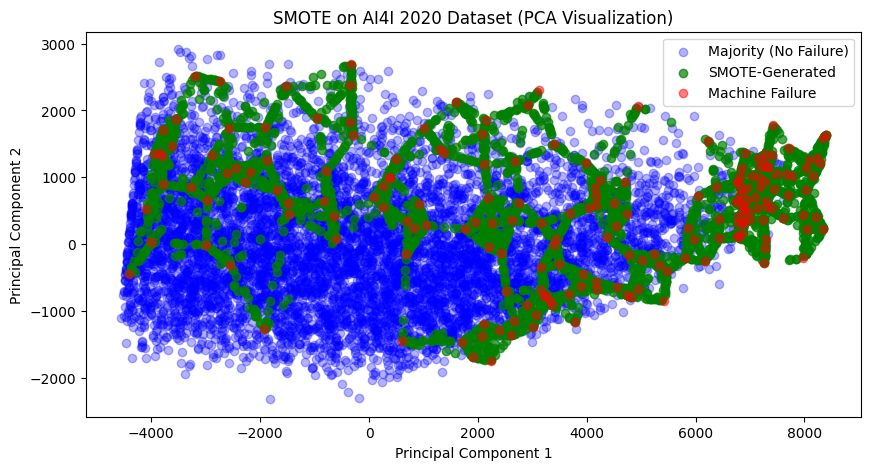

In [40]:
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
smote = SMOTE(random_state=42, k_neighbors=5)
y_omf = y_train["Machine failure"]

# we try to suee what happened if we use standard scaler before smote but the effect is negligible
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_train)
X_scaled = X_train
X_resampled_train, y_resample_train = smote.fit_resample(X_scaled, y_omf)
print(f"Oversampling completed with {len(y_resample_train)} samples.")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_resampled_pca = pca.transform(X_resampled_train)

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[y_omf == 0, 0], X_pca[y_omf == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
plt.scatter(X_resampled_pca[len(X):, 0], X_resampled_pca[len(X):, 1], label="SMOTE-Generated", alpha=0.7, c="green")
plt.scatter(X_pca[y_omf == 1, 0], X_pca[y_omf == 1, 1], label="Machine Failure", alpha=0.5, c="red")
plt.title("SMOTE on AI4I 2020 Dataset (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

We can see from the plot above, SMOTE may amplify noise where there could be class overlap as boundary between majority and minority class is not very well defined

There is a good likelihood that SMOTE may actually worsen our prediction ability due to class overlap

It will be interesting to see the boundaries of each failure to see which one has the most or least class overlap from our majority class

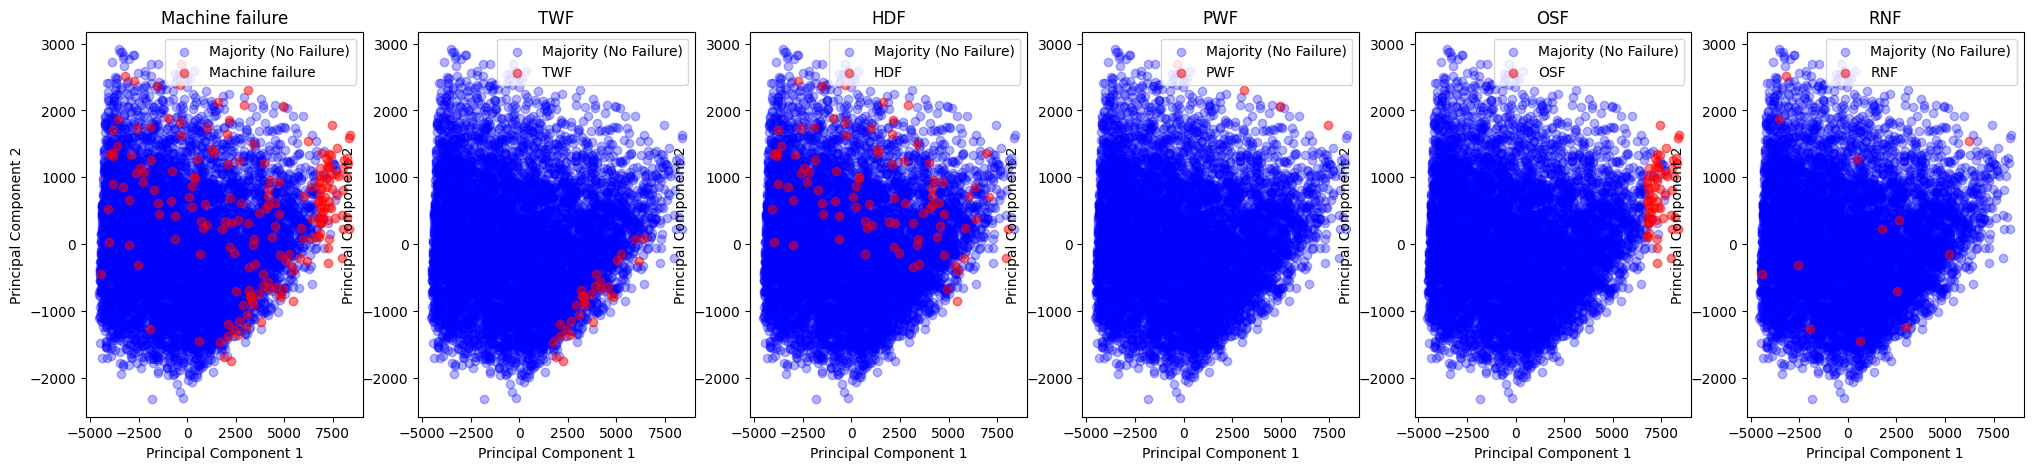

In [41]:
labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
plt.figure(figsize=(25, 5))
i=0
for label in labels:
    i+=1
    y_f=y_train[label]
    plt.subplot(1,6,i)
    plt.scatter(X_pca[y_f == 0, 0], X_pca[y_f == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
    plt.scatter(X_pca[y_f == 1, 0], X_pca[y_f == 1, 1], label=label, alpha=0.5, c="red")
    plt.title(label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
plt.show()

From our PCA analysis, instead of basing SMOTE on `Machine Failure`, we could consider `TWF`,`PWF` and `OSF` to avoid class overlap 

For SMOTE it is hard to find proper implementation of Multi-Label SMOTE (MLSMOTE), we tried but unable to find a working code 

We will explore alternative method to balance our data


### Balancing using Randomly Over Sampling

We are not able to find any good random sampler or smote implementation for our multi-label dataset

Hence we roll out our own simple random over sampler

In [42]:
from collections import Counter


def multilabel_random_oversample(X, y):
    # Convert each row of `y` to a tuple (hashable for counting)
    y_combinations = [tuple(row) for row in y.values]
    combo_counts = Counter(y_combinations) # count all possible combinations
    # Determine max samples per combo (or set a fixed target)
    max_samples = max(combo_counts.values())  # count majority ( likely pass )
    other_count = sum(combo_counts.values())-max_samples # count total of minority
    needed_samples = max_samples-other_count
    if other_count == 0 : # fail to sample as there is no minority class
        return X,y
    multiplier = needed_samples//other_count  # multiplier factor to maintain the same ratio for each label
    print(f" add {needed_samples} samples to create balanced data set ")
    # Collect indices of samples to duplicate
    indices_to_add = []
    for combo, count in combo_counts.items():
        if count < max_samples:
            needed = multiplier*count
            print(f" add {needed:10} samples  for {combo} ")
            indices = [i for i, lbl in enumerate(y_combinations) if lbl == combo]
            selected = np.random.choice(indices, size=needed, replace=True)
            indices_to_add.extend(selected)
    # Concatenate original + oversampled data
    X_resampled = pd.concat([X, X.iloc[indices_to_add]], axis=0)
    y_resampled = pd.concat([y, y.iloc[indices_to_add]], axis=0)    
    return X_resampled, y_resampled

X_ros, y_ros = multilabel_random_oversample(X_train, y_train)

 add 7129 samples to create balanced data set 
 add       2124 samples  for (1, 0, 0, 0, 1, 0) 
 add       3096 samples  for (1, 0, 1, 0, 0, 0) 
 add       1008 samples  for (1, 1, 0, 0, 0, 0) 
 add        108 samples  for (1, 0, 1, 0, 1, 0) 
 add        108 samples  for (1, 0, 0, 1, 0, 0) 
 add        432 samples  for (1, 0, 0, 0, 0, 1) 
 add         36 samples  for (1, 1, 0, 0, 0, 1) 
 add         36 samples  for (1, 0, 0, 1, 1, 0) 


Machine failure
0    7322
1     193
Name: count, dtype: int64
Machine failure
0    7322
1    7141
Name: count, dtype: int64


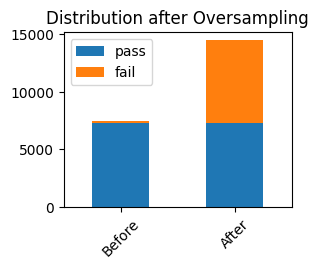

In [43]:
plt.figure(figsize=(10, 5))
y_omf = y_train["Machine failure"]
y_rmf = y_ros["Machine failure"]
before_count = y_omf.value_counts()
after_count = y_rmf.value_counts()
print(before_count)
print(after_count)
temp = pd.DataFrame({'pass': [before_count[0], after_count[0]],
                        'fail': [before_count[1], after_count[1]], },
                    index=['Before', 'After'])
temp.plot(kind='bar', stacked=True, ax=plt.subplot(2, 3, index + 1))
plt.xticks(rotation=45)
plt.title("Distribution after Oversampling")
plt.show()


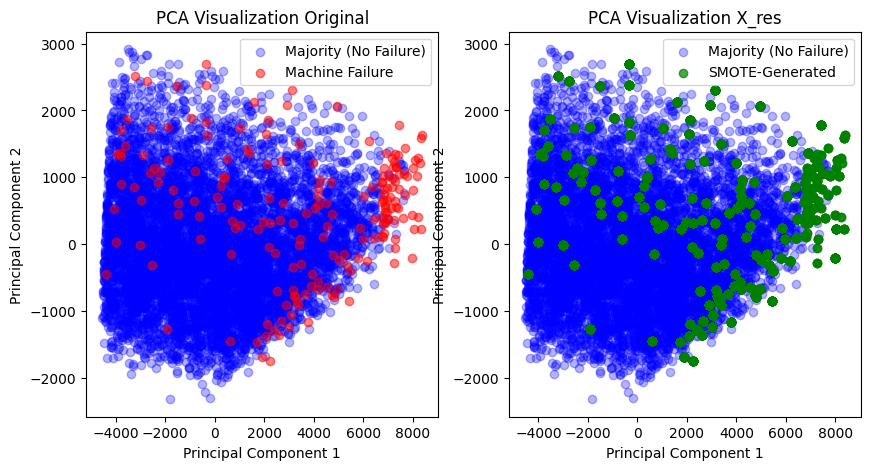

In [44]:
from sklearn.decomposition import PCA
y_omf = y_train["Machine failure"]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_resampled_pca = pca.transform(X_ros)
# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.scatter(X_pca[y_omf == 0, 0], X_pca[y_omf == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
plt.scatter(X_pca[y_omf == 1, 0], X_pca[y_omf == 1, 1], label="Machine Failure", alpha=0.5, c="red")
plt.title("PCA Visualization Original")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.subplot(1,2,2)
plt.scatter(X_pca[y_omf == 0, 0], X_pca[y_omf == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
plt.scatter(X_resampled_pca[len(X):, 0], X_resampled_pca[len(X):, 1], label="SMOTE-Generated", alpha=0.7, c="green")
plt.title("PCA Visualization X_res")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.show()

The PCA plot does not show any changes. This is expected as our random over sampler simply duplicate existing targets without introducing new synthetic data

#### Save Random Over Sampler Dataset

In [45]:
X_ros.to_csv('data/X_ros_train.csv', index=False)
y_ros.to_csv('data/y_ros_train.csv', index=False)

### Balancing using MLSMOTE

This is code is a modified code from https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87 
or https://github.com/niteshsukhwani/MLSMOTE?tab=readme-ov-file


In [46]:
# -*- coding: utf-8 -*-
# Importing required Library
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import NearestNeighbors
from collections import Counter


def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X,n_neighbors):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=n_neighbors,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def generate_syntethic_sample(X,y, n_sample,n_neighbors):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X,n_neighbors)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target


def multilabel_smote(X, y,n_neighbors=5):
    # Convert each row of `y` to a tuple (hashable for counting)
    y_combinations = [tuple(row) for row in y.values]
    combo_counts = Counter(y_combinations) # count all possible combinations
    # Determine max samples per combo (or set a fixed target)
    max_samples = max(combo_counts.values())  # count majority ( likely pass )
    other_count = sum(combo_counts.values())-max_samples # count total of minority
    needed_samples = max_samples-other_count
    if other_count == 0 : # fail to sample as there is no minority class
        return X,y
    X_min,y_min=get_minority_instace(X,y) # minority instances
    X_new,y_new=generate_syntethic_sample(X_min,y_min, needed_samples,n_neighbors)
    # Concatenate original + oversampled data
    X_resampled = pd.concat([X, X_new], axis=0)
    y_resampled = pd.concat([y, y_new], axis=0)    
    return X_resampled, y_resampled

X_mls, y_mls = multilabel_smote(X_train, y_train,n_neighbors=5)

Machine failure
0    7322
1     193
Name: count, dtype: int64
Machine failure
1.0    7339
0.0    7322
Name: count, dtype: int64


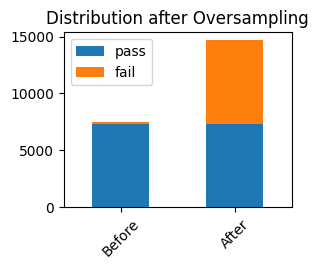

In [47]:
plt.figure(figsize=(10, 5))
y_omf = y_train["Machine failure"]
y_rmf = y_mls["Machine failure"]
before_count = y_omf.value_counts()
after_count = y_rmf.value_counts()
print(before_count)
print(after_count)
temp = pd.DataFrame({'pass': [before_count[0], after_count[0]],
                        'fail': [before_count[1], after_count[1]], },
                    index=['Before', 'After'])
temp.plot(kind='bar', stacked=True, ax=plt.subplot(2, 3, index + 1))
plt.xticks(rotation=45)
plt.title("Distribution after Oversampling")
plt.show()


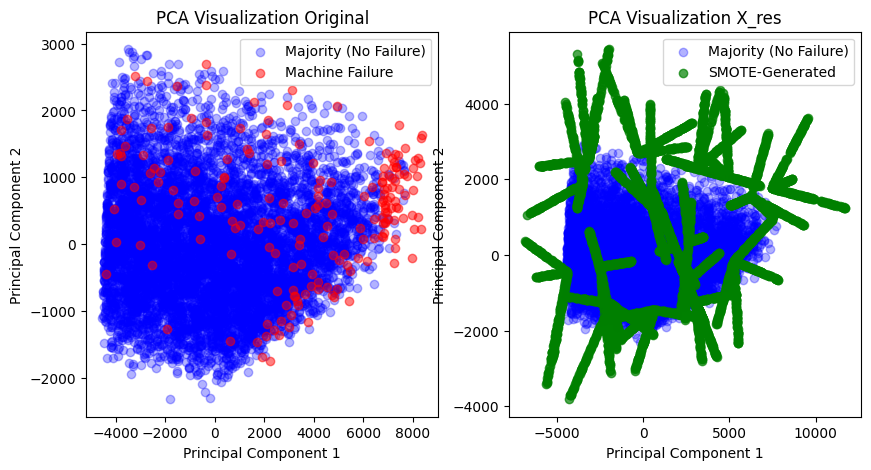

In [48]:
from sklearn.decomposition import PCA
y_omf = y_train["Machine failure"]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_resampled_pca = pca.transform(X_mls)
# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.scatter(X_pca[y_omf == 0, 0], X_pca[y_omf == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
plt.scatter(X_pca[y_omf == 1, 0], X_pca[y_omf == 1, 1], label="Machine Failure", alpha=0.5, c="red")
plt.title("PCA Visualization Original")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.subplot(1,2,2)
plt.scatter(X_pca[y_omf == 0, 0], X_pca[y_omf == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
plt.scatter(X_resampled_pca[len(X):, 0], X_resampled_pca[len(X):, 1], label="SMOTE-Generated", alpha=0.7, c="green")
plt.title("PCA Visualization X_res")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.show()

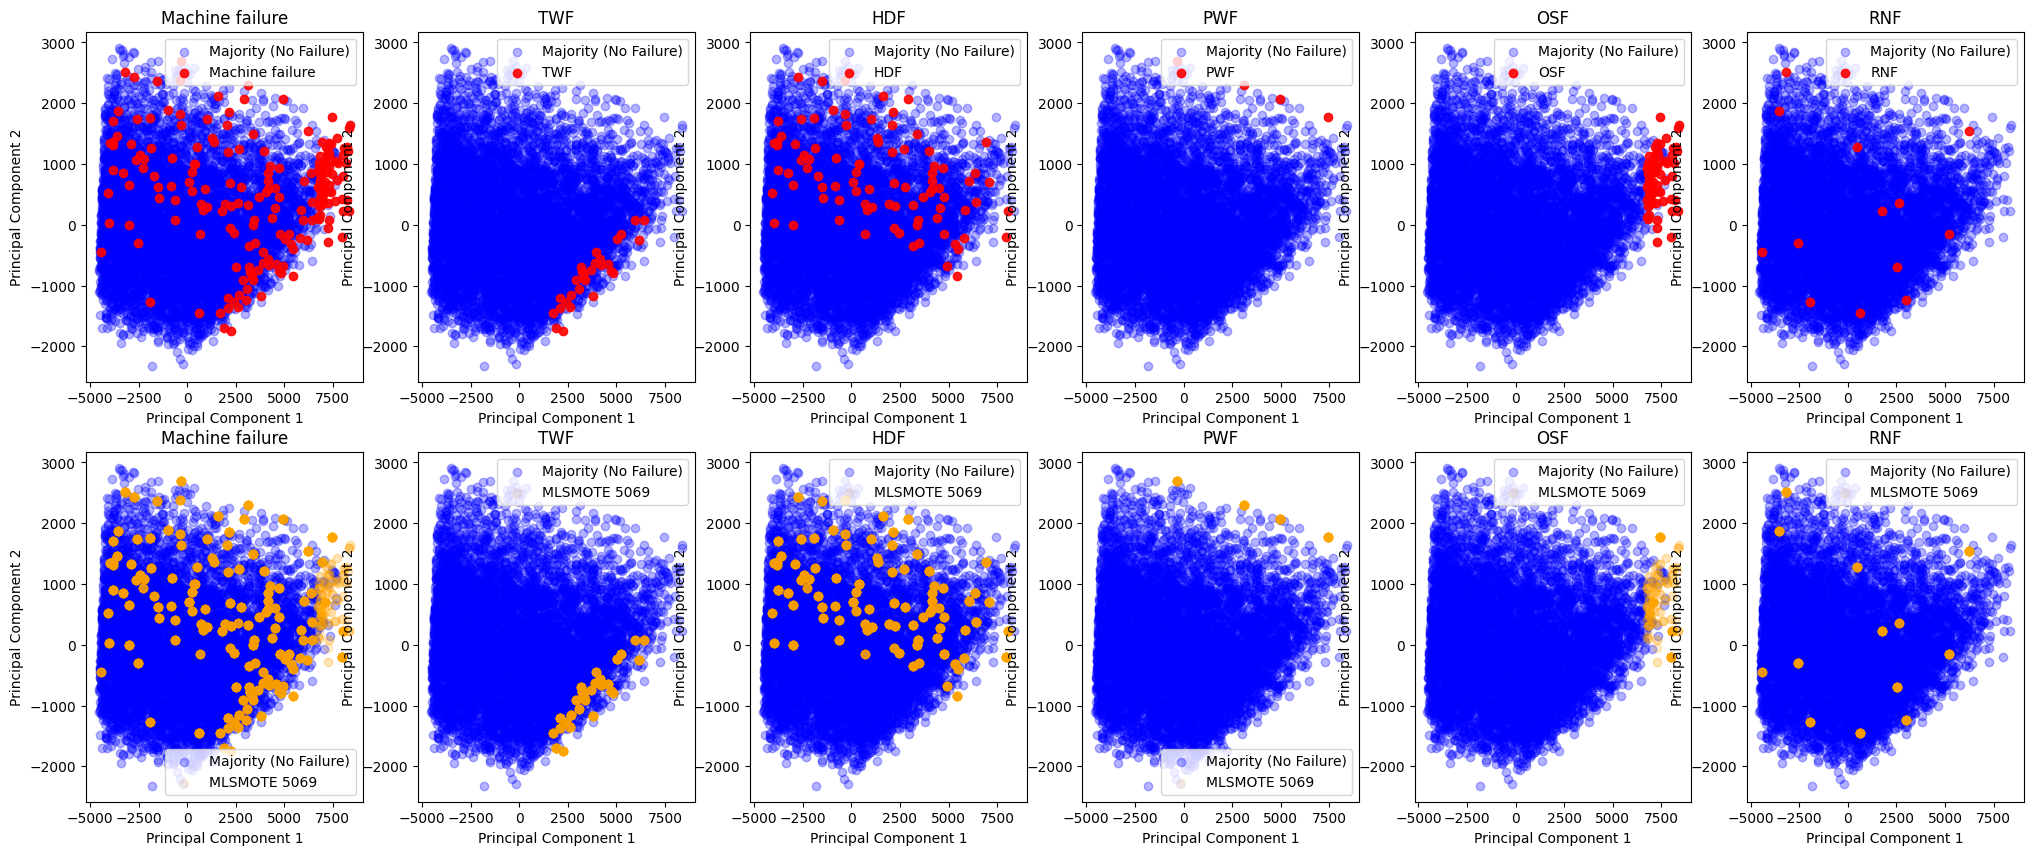

In [49]:
X_resampled_pca = pca.transform(X_ros)

labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
plt.figure(figsize=(25, 10))
i=0
for label in labels:
    i+=1
    y_f=y_train[label]
    y_s=y_ros[label][len(X):]
    plt.subplot(2,6,i)
    plt.scatter(X_pca[y_f == 0, 0], X_pca[y_f == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
    plt.scatter(X_pca[y_f == 1, 0], X_pca[y_f == 1, 1], label=label, alpha=0.9, c="red")
    plt.title(label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
for label in labels:
    i+=1
    y_f=y_train[label]
    y_s=y_ros[label][len(X):]
    extra=y_s.shape[0]
    plt.subplot(2,6,i)
    plt.scatter(X_pca[y_f == 0, 0], X_pca[y_f == 0, 1], label="Majority (No Failure)", alpha=0.3, c="blue")
    plt.scatter(X_resampled_pca[len(X):][y_s==1, 0], X_resampled_pca[len(X):][y_s==1, 1], label=f"MLSMOTE {extra}", alpha=0.1, c="orange")
    plt.title(label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
plt.show()

We can see that MLSMOTE add 5069 extra samples and it is well distributed

Hence, it seemed to work as expected

#### Save MLSMOTE Dataset

In [50]:
X_mls.to_csv('data/X_mls_train.csv', index=False)
y_mls.to_csv('data/y_mls_train.csv', index=False)